Минимальный напор: 4.774817591503393


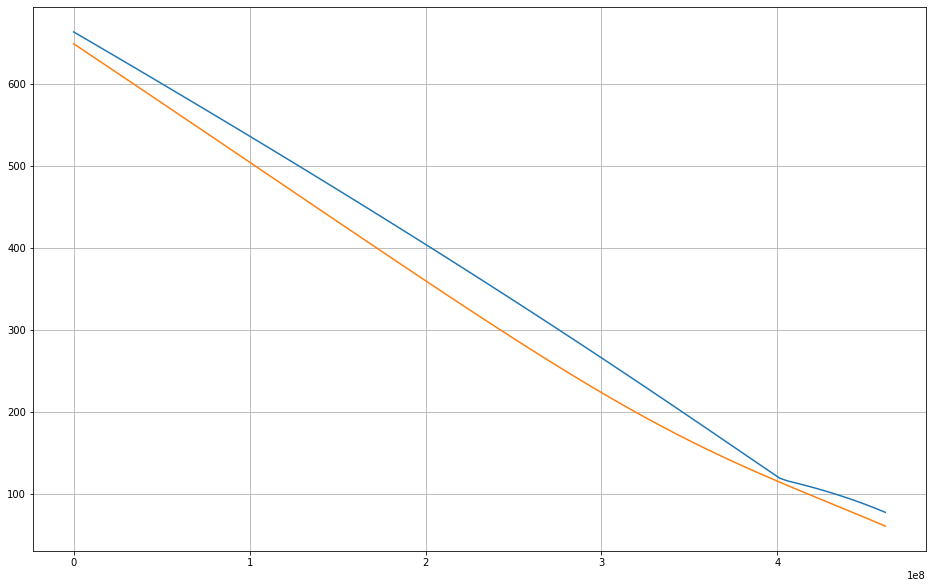

Площадь, Длина, Диаметр корпуса
11982.04970006317 112.06125683195621 1.0879999999999999 2864175.6952544376 445964.85939979553 104.18451182717475


In [5]:
#Расчёт конденсатора кожухотрубного
import matplotlib.pyplot as pt
import numpy as n
from CoolProp.CoolProp import PropsSI as p
from scipy.optimize import root
import math as m

#Исходные данные:
G1 = 636.690003
T11 = 663.629872
T12 = 77

G2 = 543.18
T21 = 60.2275183


P11=3000000
P21=30000000

##############################################
CO2  = 'REFPROP::CO2'
H2O  = 'REFPROP::WATER'
O2   = 'REFPROP::Oxygen'
MIX1 =  'REFPROP::CO2[0.931]&WATER[0.069]'
MIX2 =  'REFPROP::CO2[0.993]&WATER[0.007]'
MIX05 =  'REFPROP::CO2[0.95]&WATER[0.05]' #Для транспортных свойств

H11  = p('H','T', T11+273.15, 'P', P11, MIX1)
H12  = p('H','T', T12+273.15, 'P', P11, MIX1)
H21  = p('H','T', T21+273.15, 'P', P21, MIX2)

#Разбиение по энтальпии:
s    = 100 #Кол-во шагов
step = (H11-H12)/(s) 

#Нулевые массивы:
t1   = n.zeros(s+1)
t2   = n.zeros(s+1)
Q    = n.zeros(s+1)
t1av = n.zeros(s)
t2av = n.zeros(s)
ro1 = n.zeros(s)
ro2 = n.zeros(s)
nu1 = n.zeros(s)
nu2 = n.zeros(s)
lambda1 = n.zeros(s)
lambda2 = n.zeros(s)
Pr1 = n.zeros(s)
Pr2 = n.zeros(s)
DTav = n.zeros(s)
w1 = n.zeros(s)
w2= n.zeros(s)
Re1= n.zeros(s)
Re2= n.zeros(s)
Nu1= n.zeros(s)
Nu2= n.zeros(s)
f1= n.zeros(s)
f2= n.zeros(s)
fNu1= n.zeros(s)
fNu2= n.zeros(s)
alpha1= n.zeros(s)
alpha2= n.zeros(s)
K= n.zeros(s)
F= n.zeros(s+1)
L= n.zeros(s+1)
P2= n.zeros(s+1)
P1= n.zeros(s+1)
tw2 = n.zeros(s+1)

#Противоток:
h11 = H11
i=0
for i in range(s+1):
    t1[i] = p('T','H', h11, 'P', P11, MIX1)-273.15 
    h12 = h11 - step
    dQ = G1 * (h11-h12)
    if i < s:
        Q[i+1]=Q[i]+dQ
    h11 = h12
h21 = H21
i=0
for i in range(s+1):
    t2[s-i] = p('T','H', h21, 'P', P21, MIX2)-273.15  
    h22 = h21+((Q[s-i]-Q[s-i-1])/G2)
    h21 = h22
DT=t1-t2

print('Минимальный напор:',min(DT))
x  = [Q[i] for i in range(s+1)]  
y1 = [t1[i] for i in (range(s+1))]
y2 = [t2[i] for i in (range(s+1))]
pt.figure(figsize=(16, 10))
pt.plot(x, y1,x,y2)
pt.grid(True)
pt.show()

#Геометрия:
Dvnes = 0.016 #Внешний диаметр трубки https://docs.cntd.ru/document/1200001411
DeltaTube = 0.001
DeltaKorp = 0.02
Dvnut = Dvnes-2*DeltaTube
steptube = Dvnes*1.2
lambdaw = 20
delta = 10**-5 #Шероховатость
dh1 = Dvnes
dh2 = Dvnut

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
w2out=2
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

#Количество труб по диаметру:
roout2 = p('D','T', t2[s]+273.15, 'P', P21, MIX2)
Fproh2 = G2/(w2out*roout2)

Ntubes = m.ceil(Fproh2/((n.pi*Dvnut**2)/4))

summ = 0
nd=0
n2 = 0
while n2 < Ntubes:
    summ = summ + nd
    n2=1+6*summ
    nd=nd+1
nd = 1+2*(nd-1)
Ntubes = n2
Dkorp = nd*steptube+2*Dvnes
Fproh1 = ((n.pi*Dkorp**2)/4)-(Ntubes*(n.pi*Dvnes**2)/4)
Fl = n.pi*((Dvnes+Dvnut)/2)*Ntubes

P2[0]=P21
P1[0]=P11

#Зона охлаждения:
for i in range(s):
    #Свойства
    t1av[i]   =(t1[i]+t1[i+1])/2
    t2av[i]   =(t2[i]+t2[i+1])/2
    ro1[i]    =p('D','T', t1av[i]+273.15, 'P', P11, MIX1)
    ro2[i]    =p('D','T', t2av[i]+273.15, 'P', P21, MIX2)
    nu1[i]    =p('V','T', t1av[i]+273.15, 'P', P11, MIX05)/ro1[i]
    nu2[i]    =p('V','T', t2av[i]+273.15, 'P', P21, MIX05)/ro2[i]
    lambda1[i]=p('L','T', t1av[i]+273.15, 'P', P11, MIX05)
    lambda2[i]=p('L','T', t2av[i]+273.15, 'P', P21, MIX05)
    Pr1[i]    =p('PRANDTL','T', t1av[i]+273.15, 'P', P11, MIX05)
    Pr2[i]    =p('PRANDTL','T', t2av[i]+273.15, 'P', P21, MIX05)
    if abs(Pr1[i]-Pr1[i-1])>Pr1[i-1]:
        Pr1[i]=p('PRANDTL','T', t1[i]+273.15, 'P', P11, CO2)
    if abs(Pr2[i]-Pr2[i-1])>Pr2[i-1]:
        Pr2[i]=p('PRANDTL','T', t2[i]+273.15, 'P', P21, CO2)
    DTav[i]   =t1av[i]-t2av[i]
    w1[i] = G1/(ro1[i]*Fproh1)
    w2[i] = G2/(ro2[i]*Fproh2)
    Re1[i] = w1[i]*dh1/nu1[i]
    Re2[i] = w2[i]*dh2/nu2[i]
    Nu2[i] = 0.021*Re2[i]**0.8*Pr2[i]**0.43
    def func(x):
        delta = 10**-5
        left = x
        right = 1/(2*n.log10((2.51/(Re2[i]*(x)**(1/2)))+(delta/3.7)))**2
        return left-right
    sol = root(func, 0.01)
    f2[i]=float(sol.x)
    def func(x):
        delta = 10**-5
        left = x
        right = 1/(2*n.log10((2.51/(Re1[i]*(x)**(1/2)))+(delta/3.7)))**2
        return left-right
    sol = root(func, 0.01)
    f1[i]=float(sol.x)
    alpha2[i] = Nu2[i]*lambda2[i]/dh2
    w1[i] = G1/(ro1[i]*Fproh1)
    Re1[i] = w1[i]*Dvnes/nu1[i]
    Nu1[i] = 0.22*(Re1[i]**0.65)*(Pr1[i]**0.36)
    alpha1[i] = Nu1[i]*lambda1[i]/dh1
    K[i] = 1/((1/alpha1[i])+(1/alpha2[i])+((((Dvnes+Dvnut)/2)/(2*lambdaw))*(n.log(Dvnes/Dvnut))))
    dF = (Q[i+1]-Q[i])/(K[i]*DTav[i])
    dL = dF/Fl
    if i < s:
        F[i+1]=F[i]+dF
    if i < s:
        L[i+1]=L[i]+dL
    dP2 = f2[i]*dL/dh2*ro2[i]*w2[i]**2/2
    dP1 = f1[i]*dL/dh1*ro1[i]*w1[i]**2/2
    if i < s:
        P2[i+1]=P2[i]-dP2
        P1[i+1]=P1[i]-dP1


DP1 = P1[0]-P1[s]
DP2 = P2[0]-P2[s]
print('Площадь,','Длина,','Диаметр корпуса')
print(F[s],L[s],Dkorp,DP1, DP2, L[s]*n.pi*(Dkorp**2)/4)
